In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# sanjuan_dataset = pd.read_csv("../../dengueData/SanJuan/san_juan_training_data.csv")
sanjuan_dataset = pd.read_csv("drive/My Drive/cdcDengue/dengueData/SanJuan/san_juan_training_data.csv")
print(sanjuan_dataset.head())
print("Number of observations: ", len(sanjuan_dataset))

      season  season_week week_start_date  denv1_cases  denv2_cases  \
0  1990/1991            1      1990-04-30            0            0   
1  1990/1991            2      1990-05-07            0            0   
2  1990/1991            3      1990-05-14            0            0   
3  1990/1991            4      1990-05-21            0            0   
4  1990/1991            5      1990-05-28            0            0   

   denv3_cases  denv4_cases  other_positive_cases  additional_cases  \
0            0            0                     4                 0   
1            0            0                     5                 0   
2            0            0                     4                 0   
3            0            0                     3                 0   
4            0            0                     6                 0   

   total_cases  
0            4  
1            5  
2            4  
3            3  
4            6  
Number of observations:  988


In [4]:
sanjuan_cases = sanjuan_dataset["total_cases"].values
print(sanjuan_cases.shape)

(988,)


In [0]:
def series_to_timeseries_window(data, windowSize):
    x = []
    y = []
    future_steps = 0
    for i in range(len(data)-windowSize-future_steps):
        x_observation = []
        y_observation = [data[i+windowSize+future_steps]]
        for j in range(windowSize):
            x_observation.append(data[i+j])
        x.append(x_observation)
        y.append(y_observation)
    return np.array(x), np.array(y)

In [6]:
#Test that the method works
test_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

tX, ty = series_to_timeseries_window(test_data, 4)

print(tX)
print(ty)

print(len(tX))

[[ 1  2  3  4]
 [ 2  3  4  5]
 [ 3  4  5  6]
 [ 4  5  6  7]
 [ 5  6  7  8]
 [ 6  7  8  9]
 [ 7  8  9 10]
 [ 8  9 10 11]
 [ 9 10 11 12]
 [10 11 12 13]
 [11 12 13 14]]
[[ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]]
11


In [0]:
split_index = int(len(sanjuan_cases)* 0.7)
reframed_X, reframed_y = series_to_timeseries_window(sanjuan_cases, 4)

train_X = reframed_X[:split_index]
train_y = reframed_y[:split_index]

test_X = reframed_X[split_index:]
test_y = reframed_y[split_index:]

train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])

test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])

In [8]:
print(train_X.shape)
print(train_y.shape)

print(test_X.shape)
print(test_y.shape)

# print(train_X[-5:])
# print(train_y[-5:])

# print(test_X[:5])
# print(test_y[:5])

# # print(test_X[-10:])
# # print(test_y[-10:])
# # print(iquitos_cases[-10:])

(691, 1, 4)
(691, 1)
(293, 1, 4)
(293, 1)


## Train model

Using TensorFlow backend.


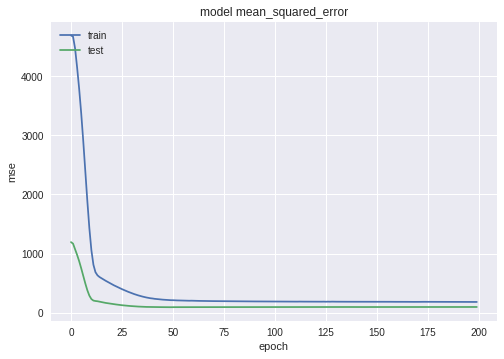

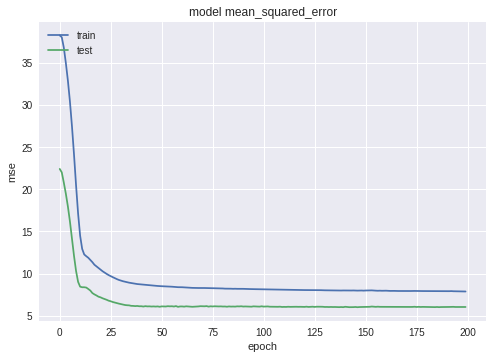

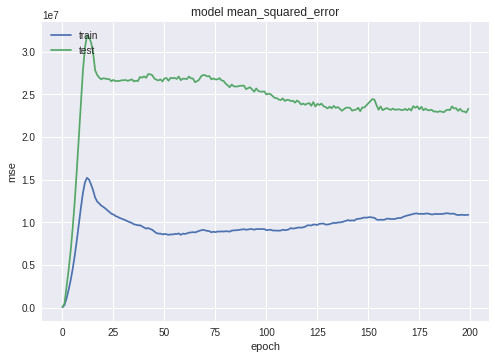

In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Flatten
from keras.layers.merge import concatenate
from keras.constraints import non_neg
from keras.models import Model
from sklearn.metrics import mean_squared_error
input_layer = Input(shape=(1,4))
b1_out = LSTM(64, return_sequences=False)(input_layer)

b2_out = Dense(32, activation="relu", kernel_regularizer="l2")(input_layer)
b2_out = Flatten()(b2_out)

concatenated = concatenate([b1_out, b2_out])
out = Dense(4, activation="relu", kernel_regularizer="l2")(concatenated)
out = Dense(4, activation="relu", kernel_regularizer="l2")(out)
out = Dense(1, activation="linear", kernel_constraint=non_neg(), name='output_layer')(out)

model = Model([input_layer], out)
model.compile(loss=["mse"], optimizer="adam", metrics=["mae", "mse", "mean_absolute_percentage_error"])


history = model.fit(train_X, train_y, epochs=200, batch_size=32, verbose=0, shuffle=False, validation_data=(test_X, test_y))

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_squared_error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mean_absolute_percentage_error'])
plt.plot(history.history['val_mean_absolute_percentage_error'])
plt.title('model mean_squared_error')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

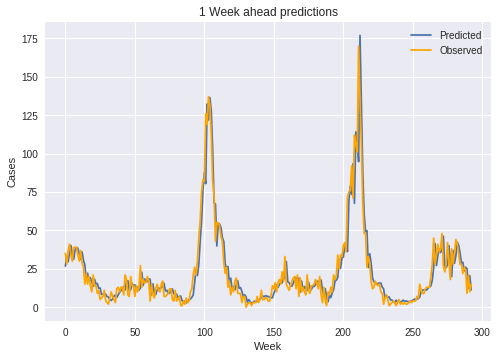

In [10]:
predictions = model.predict(test_X)
plt.title("1 Week ahead predictions")
plt.xlabel("Week")
plt.ylabel("Cases")
plt.plot(predictions, label="Predicted")
plt.plot(test_y, label = "Observed", color="orange")
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test_y, predictions)

print(error)

94.96707589560897


## Test Model

In [12]:
validation_dataset = pd.read_csv("drive/My Drive/cdcDengue/dengueData/SanJuan/san_juan_testing_data.csv")
validation_dataset.head()

,season,season_week,week_start_date,denv1_cases,denv2_cases,denv3_cases,denv4_cases,other_positive_cases,additional_cases,total_cases
0,1990/1991,1,1990-04-30,0,0,0,0,4,0,4
1,1990/1991,2,1990-05-07,0,0,0,0,5,0,5
2,1990/1991,3,1990-05-14,0,0,0,0,4,0,4
3,1990/1991,4,1990-05-21,0,0,0,0,3,0,3
4,1990/1991,5,1990-05-28,0,0,0,0,6,0,6


In [0]:
validation_cases = validation_dataset["total_cases"].values
validation_X, validation_y = series_to_timeseries_window(validation_cases, 4)
validation_X = validation_X.reshape(validation_X.shape[0], 1, validation_X.shape[1])

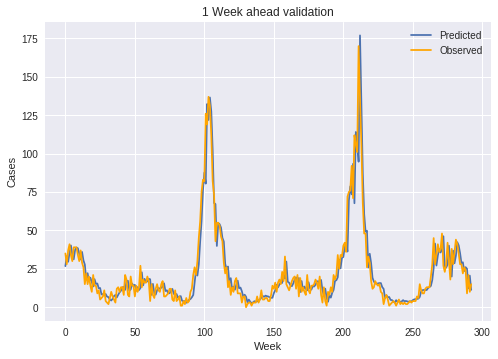

In [17]:
validation_predictions = model.predict(validation_X)

plt.title("1 Week ahead validation")
plt.xlabel("Week")
plt.ylabel("Cases")
plt.plot(predictions, label="Predicted")
plt.plot(test_y, label = "Observed", color="orange")
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(validation_y, validation_predictions)

print(error)

182.684443910591
